In [1]:
import math
import os
import sys
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
from mxnet import gluon, autograd
from mxnet.gluon import nn, rnn


#let's use cpu for now
context = mx.cpu()

In [2]:
# module imports
from NLP.src.training import model, training, utils
from NLP.src.decoder import decoder
from NLP.src.pre_processing import pre_process

# Create a sequence
We don't want the sequence to be completely random, otherwise the RNN won't be able to learn much

When we got a word sequence, we need to map each unique word to an integer and the integer sequence will be fed into the neural net

In [4]:
seq, word_idx, idx_word = pre_process.pre_process('sample_txt.txt')

In [5]:
seq = mx.nd.array(seq, ctx=context)
vocab_size = len(word_idx)

In [7]:
seq


[2384. 1852. 2001. ... 2446. 1938. 1929.]
<NDArray 9323 @cpu(0)>

# DL portion

In [9]:
x = utils.batchify(seq, 32)
print('batchified data: ', x)
y = utils.get_batch(x, 0)
print('first batch: ', y)

batchified data:  
[[2384. 1457.  187. ... 2384.  228. 2384.]
 [1852. 2727. 1975. ... 2723. 2687. 2321.]
 [2001. 2384. 2155. ... 2658.   13. 2599.]
 ...
 [2106.  803. 1278. ... 1728.  812. 1929.]
 [2134. 1916. 2580. ... 2162. 2599. 2722.]
 [ 352. 2722. 2170. ... 2090. 1000. 1967.]]
<NDArray 291x32 @cpu(0)>
first batch:  (
[[2384. 1457.  187.  539.  181. 2638. 1702.  537. 1068.  914. 2687. 2638.
   349.   47. 2054. 1830.  683. 1000. 1736.  437. 2384. 2083. 2687.   29.
   921. 2239. 1039. 2296.  235. 2384.  228. 2384.]]
<NDArray 1x32 @cpu(0)>, 
[1852. 2727. 1975. 1156. 1237.   38.  725.  703. 2384.  918. 2231.   38.
 1631. 2604. 2740. 1289. 1234.  812. 1000. 2722. 1693. 2638. 2384. 2567.
 1000. 2307.  133. 2341.   38. 2723. 2687. 2321.]
<NDArray 32 @cpu(0)>)


### training loop

## Prepare for training

In [10]:
#model constants
num_embed = 5
num_hidden = 5
num_layers = 2

#training constants
args_lr = 1
args_epochs = 30
args_batch_size = 32

In [11]:
train_data = utils.batchify(seq, args_batch_size).as_in_context(context)

In [12]:
# define model and loss
# we do dropout=0 here to promote overfitting, on real data we might want a positive value
model_ = model.RNNModel(mode='gru', vocab_size=vocab_size, num_embed=num_embed, num_hidden=num_hidden,
                 num_layers=num_layers, dropout=0)
model_.collect_params().initialize(mx.init.Xavier(), ctx=context)
trainer = gluon.Trainer(model_.collect_params(), 'sgd',
                        {'learning_rate': args_lr, 'momentum': 0, 'wd': 0})
loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [13]:
seed_list = ('he is').split(' ')
seed_seq = [word_idx[w] for w in seed_list]
seed_seq

[314, 1975]

In [14]:
decoder_greedy = decoder.Decoder(model_, context=context)
seq_output, _ = decoder_greedy.decode(seed_seq, 10)
' '.join([idx_word[idx] for idx in seq_output])

'giammai fee create synonymous distributor keen padding permanent subtlety evenings'

# Finally, train the RNN

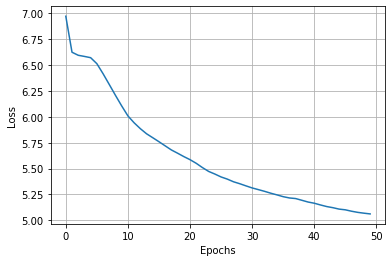

In [15]:
# finally train the model
trainer = gluon.Trainer(model_.collect_params(), 'sgd',
                        {'learning_rate': 1, 'wd': 0})
args_epochs = 50
training.train(train_data=train_data, model=model_, trainer=trainer, 
               loss=loss, args_epochs=args_epochs, args_batch_size=args_batch_size,
                context=context)

# Decoder, use the RNN we just learned to generate a sequence

## Here we just use a gready decoder, may do something fancier later

In [16]:
seed_list = ('he is').split(' ')
seed_seq = [word_idx[w] for w in seed_list]
seed_seq

[314, 1975]

In [20]:
decoder_sample = decoder.Decoder(model_, mode='sample', n=100, context=context)
seq_output, ppensity = decoder_sample.decode(seed_seq, 20)
' '.join([idx_word[idx] for idx in seed_seq + seq_output])

'he is agreed to refund i provide the highest giving a terms of steam all the terms of weave the door he'

# Auxiliary cells, don't read

In [24]:
mx.nd.array(np.arange(100))


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 91. 92. 93. 94. 95. 96. 97. 98. 99.]
<NDArray 100 @cpu(0)>

In [ ]:
embed = model_.encoder.weight.data()
norms = (embed**2).sum(axis = 1)
norms = norms.asnumpy()
plt.plot(np.arange(vocab_size), norms)

In [ ]:
norms[1171]

In [ ]:
embed[877], norms[877]

In [ ]:
seed = mx.nd.array([[0]])
seq_length = 50

hidden = model.begin_state(func=mx.nd.zeros, batch_size=1, ctx=context)
output, hidden = model(seed, hidden)
plt.plot(np.arange(vocab_size), output[0].asnumpy())